In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.io import loadmat
import matplotlib.cm as cm
import time
import skimage.measure
import os
from keras.initializers import RandomNormal
from keras.callbacks import ModelCheckpoint

In [2]:
def density_map_1_over_8(image, heads):
    image = skimage.measure.block_reduce(image, (2,2,1), np.max)
    image = skimage.measure.block_reduce(image, (2,2,1), np.max)
    image = skimage.measure.block_reduce(image, (2,2,1), np.max)
    
    output = np.zeros(image.shape[:-1])
    x = heads["image_info"][0, 0][0, 0][0][:,0]/8
    y = heads["image_info"][0, 0][0, 0][0][:,1]/8
    
    for x_choord, y_choord in zip(x, y):
        density_i = np.zeros(image.shape[:-1])
        try:
            density_i[round(y_choord),round(x_choord)] = 1
        except:
            pass
        nearest_distance = np.min(np.linalg.norm(x_choord - y_choord))
        sigma = 0.3 * nearest_distance # beta = 0.3 suggested by MCNN paper
        kernel_size = 3
            
        density_i = cv2.GaussianBlur(density_i, (kernel_size,kernel_size), sigma)
        output += density_i
    return cv2.GaussianBlur(output, (5,5), sigma)

In [3]:
path_images = "../input/shanghaitech/ShanghaiTech/part_B/train_data/images/"
path_heads = "../input/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth/"
try:
    os.makedirs('../outputs/train/maps/')
except:
    pass
path_save = "../outputs/train/maps/"

for i, (img_name, heads_name) in enumerate(zip(sorted(os.listdir(path = path_images)), sorted(os.listdir(path = path_heads)))):   
    img = cv2.cvtColor(cv2.imread(path_images + img_name), cv2.COLOR_BGR2RGB)  
    heads = loadmat(path_heads + heads_name)
    ds_map_1o8 = density_map_1_over_8(img, heads)
    np.save(path_save + img_name[:-4], ds_map_1o8)
    
    if i % 10 == 0:
        print(f"{i+1} density maps done")

1 density maps done
11 density maps done
21 density maps done
31 density maps done
41 density maps done
51 density maps done
61 density maps done
71 density maps done
81 density maps done
91 density maps done
101 density maps done
111 density maps done
121 density maps done
131 density maps done
141 density maps done
151 density maps done
161 density maps done
171 density maps done
181 density maps done
191 density maps done
201 density maps done
211 density maps done
221 density maps done
231 density maps done
241 density maps done
251 density maps done
261 density maps done
271 density maps done
281 density maps done
291 density maps done
301 density maps done
311 density maps done
321 density maps done
331 density maps done
341 density maps done
351 density maps done
361 density maps done
371 density maps done
381 density maps done
391 density maps done


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import SGD
from keras.models import model_from_json

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [8]:
Train_imgs_B = []
Train_density_B = []
Train_labels_B = []

path_images = "../input/shanghaitech/ShanghaiTech/part_B/train_data/images/"
path_heads = "../input/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth/"
path_maps = "../outputs/train/maps/"



for img_name, den_name, heads_name in zip(sorted(os.listdir(path = path_images)), sorted(os.listdir(path = path_maps)), sorted(os.listdir(path = path_heads))):   
    
    img = preprocess_input(cv2.cvtColor(cv2.imread(path_images + img_name), cv2.COLOR_BGR2RGB))
    Train_imgs_B.append(img)
    
    img = np.load(path_maps + den_name)
    Train_density_B.append(img)
    
    Train_labels_B.append(len(loadmat(path_heads + heads_name)['image_info'][0, 0][0, 0][0]))


Train_imgs_B = np.asarray(Train_imgs_B)
Train_density_B = np.asarray(Train_density_B)

In [4]:
VGG_16 = VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))

In [5]:
VGG_16 = Model(VGG_16.input, VGG_16.layers[-6].output)

for layer in VGG_16.layers[:]:
    layer.trainable = False


Map_estimator_net = Sequential([
            Conv2D(512, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),
            Conv2D(512, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),
            Conv2D(512, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),
            Conv2D(256, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),
            Conv2D(128, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),
            Conv2D(64, (3, 3), dilation_rate = 2, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01),        
            Conv2D(1, (1, 1), dilation_rate = 1, padding = 'same', kernel_initializer = RandomNormal(stddev=0.01)),
            LeakyReLU(alpha=0.01)
            ])(VGG_16.output)

CSRnet = Model(inputs=VGG_16.input, outputs=Map_estimator_net)
CSRnet.compile(optimizer=SGD(lr = 1e-2, decay = (5*1e-4), momentum = 0.9), loss = "mse", metrics=["mae"])
CSRnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [8]:
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)

history = CSRnet.fit(Train_imgs_B, Train_density_B,
                             batch_size = 1, epochs = 60,
                             validation_split=0.1, steps_per_epoch = 30,
                             callbacks=[model_checkpoint_callback]
                         )

CSRnet.load_weights(checkpoint_filepath)

Epoch 1/60
30/30 [==============================] - 126s 4s/step - loss: 0.0019 - mae: 0.0095 - val_loss: 0.0012 - val_mae: 0.0091
Epoch 2/60
30/30 [==============================] - 113s 4s/step - loss: 0.0011 - mae: 0.0091 - val_loss: 0.0012 - val_mae: 0.0100
Epoch 3/60
30/30 [==============================] - 113s 4s/step - loss: 0.0015 - mae: 0.0132 - val_loss: 0.0011 - val_mae: 0.0104
Epoch 4/60
30/30 [==============================] - 113s 4s/step - loss: 8.3772e-04 - mae: 0.0103 - val_loss: 0.0010 - val_mae: 0.0136
Epoch 5/60
30/30 [==============================] - 113s 4s/step - loss: 0.0011 - mae: 0.0090 - val_loss: 0.0011 - val_mae: 0.0088
Epoch 6/60
30/30 [==============================] - 113s 4s/step - loss: 0.0012 - mae: 0.0116 - val_loss: 9.0457e-04 - val_mae: 0.0106
Epoch 7/60
30/30 [==============================] - 113s 4s/step - loss: 0.0011 - mae: 0.0128 - val_loss: 8.4508e-04 - val_mae: 0.0084
Epoch 8/60
30/30 [==============================] - 113s 4s/step - loss

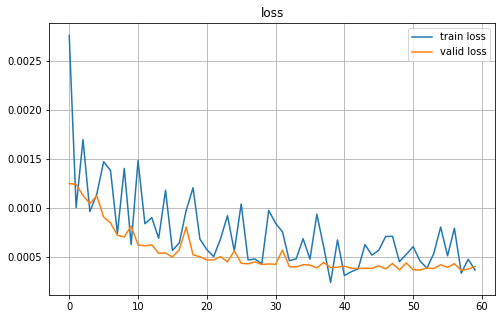

In [9]:
def plot_learning_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.epoch,history.history['loss'], label='train loss')
    plt.plot(history.epoch,history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.grid(True)
    plt.show()
plot_learning_curves(history)

In [11]:
try:
    os.makedirs('../output/')
except:
    pass

model_save_json = CSRnet.to_json()
with open("csrnet_model.json", "w") as json_file:
    json_file.write(model_save_json)

# serialize weights to HDF5
CSRnet.save_weights("csrnet_model.h5")

In [6]:
# json_file = open("csrnet_model.h5", 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# CSRnet = model_from_json(loaded_model_json)

# load weights into new model
CSRnet.load_weights("csrnet_model.h5")

In [9]:
CSRnet.trainable = True

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True)

history = CSRnet.fit(Train_imgs_B, Train_density_B,
                             batch_size = 1, epochs = 40,
                             validation_split=0.1, steps_per_epoch = 30,
                             callbacks=[model_checkpoint_callback]
                         )

CSRnet.load_weights(checkpoint_filepath)

Epoch 1/40
30/30 [==============================] - 127s 4s/step - loss: 6.2765e-04 - mae: 0.0070 - val_loss: 3.6100e-04 - val_mae: 0.0061
Epoch 2/40
30/30 [==============================] - 114s 4s/step - loss: 3.9526e-04 - mae: 0.0070 - val_loss: 3.5877e-04 - val_mae: 0.0058
Epoch 3/40
30/30 [==============================] - 114s 4s/step - loss: 3.8273e-04 - mae: 0.0059 - val_loss: 3.5336e-04 - val_mae: 0.0058
Epoch 4/40
30/30 [==============================] - 114s 4s/step - loss: 7.9937e-04 - mae: 0.0077 - val_loss: 4.1339e-04 - val_mae: 0.0077
Epoch 5/40
30/30 [==============================] - 114s 4s/step - loss: 4.3947e-04 - mae: 0.0072 - val_loss: 3.8911e-04 - val_mae: 0.0076
Epoch 6/40
30/30 [==============================] - 114s 4s/step - loss: 2.6766e-04 - mae: 0.0064 - val_loss: 3.5285e-04 - val_mae: 0.0055
Epoch 7/40
30/30 [==============================] - 114s 4s/step - loss: 3.6979e-04 - mae: 0.0062 - val_loss: 3.6694e-04 - val_mae: 0.0055
Epoch 8/40
30/30 [=========

In [ ]:
plot_learning_curves(history)

In [10]:
# serialize weights to HDF5
CSRnet.save_weights("csrnet_model.h5")